Импортируем необходимые библиотеки:

In [1]:
import os  # Импорт модуля для работы с операционной системой
import nltk  # Импорт библиотеки Natural Language Toolkit (NLTK)
import matplotlib.pyplot as plt  # Импорт библиотеки для построения графиков
import csv  # Импорт модуля для работы с файлами CSV

from nltk.corpus import stopwords  # Импорт списка стоп-слов из NLTK
from nltk.stem import SnowballStemmer  # Импорт стеммера из NLTK
from transformers import pipeline  # Импорт модуля pipeline из библиотеки transformers
from nltk.tokenize import word_tokenize  # Функция для токенизации текста
from nltk.translate.bleu_score import corpus_bleu  # Функция для вычисления BLEU
from nltk.translate.meteor_score import meteor_score  # Функция для вычисления METEOR
from rouge import Rouge  # Класс для вычисления метрики ROUGE

# Загрузка ресурсов NLTK
nltk.download('stopwords')  # Загрузка списка стоп-слов из NLTK
nltk.download('punkt')  # Загрузка пунктуации из NLTK

# Загрузка модели для перевода текста с английского на русский
translator = pipeline("translation_ru_to_en", "Helsinki-NLP/opus-mt-ru-en")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Эта функция разделяет текст из исходного файла на несколько файлов, где каждый файл содержит не более заданного количества токенов (по умолчанию 50). Текст сначала токенизируется на предложения, затем предложения разбиваются на файлы таким образом, чтобы каждый файл содержал не более максимального числа токенов. Если в тексте остались предложения после разделения на файлы, они записываются в последний файл:

In [2]:
def split_text_to_files(input_file_path, output_directory, max_tokens_per_file=50):
    # Читаем исходный текстовый файл
    with open(input_file_path, 'r', encoding='utf-8') as f:
        text = f.read()

    # Создаем директорию для сохранения разделенных текстовых файлов
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Токенизируем текст на предложения
    sentences = nltk.sent_tokenize(text)

    # Разбиваем предложения на файлы по max_tokens_per_file токенов
    file_count = 1
    tokens_count = 0
    current_sentences = []
    for sentence in sentences:
        sentence_tokens = nltk.word_tokenize(sentence)
        # Добавляем предложение в список перед проверкой токенов
        current_sentences.append(sentence)
        if tokens_count + len(sentence_tokens) <= max_tokens_per_file:
            tokens_count += len(sentence_tokens)
        else:
            # Создаем путь для нового файла
            output_file_path = os.path.join(output_directory, f"input_text ({file_count}).txt")

            # Записываем предложения в новый файл
            with open(output_file_path, 'w', encoding='utf-8') as f:
                f.write('\n'.join(current_sentences))

            # Сбрасываем счетчики для следующего файла
            file_count += 1
            current_sentences = [sentence]
            tokens_count = len(sentence_tokens)

    # Записываем оставшиеся предложения в последний файл
    if current_sentences:
        output_file_path = os.path.join(output_directory, f"input_text ({file_count}).txt")
        with open(output_file_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(current_sentences))

# Пример использования:
input_file_path = "input_text.txt"
output_directory = "input_texts"
split_text_to_files(input_file_path, output_directory)


Этот код выполняет `предобработку текста`, включая токенизацию, удаление стоп-слов на русском языке, стемминг токенов и ограничение количества токенов до 512, а затем возвращает предобработанный текст:

In [3]:
# Создание экземпляра стеммера
stemmer = SnowballStemmer("english")

# Получение списка стоп-слов на русском языке
stop_words = set(stopwords.words('english'))

# Функция предобработки текста
def preprocess_text(text):
    # Токенизация текста
    tokens = word_tokenize(text)
    
    # Удаление стоп-слов
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Стемминг токенов
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    
    # Ограничение количества токенов до 512
    limited_tokens = stemmed_tokens[:512]
    
    # Склеивание токенов обратно в строку
    preprocessed_text = ' '.join(limited_tokens)
    
    return preprocessed_text

Этот код выполняет `перевод текста из файла с английского на русский`, `предобрабатывает его`, используя функцию `preprocess_text`, затем `сохраняет результат перевода в файл`. После этого определяются пути к директориям с входными текстовыми файлами и для сохранения переведенных текстовых файлов:

In [4]:
# Функция перевода текста из файла и сохранения перевода в файл
def translate_file(input_file, output_file):
    """Translate Russian text from input file to English, preprocess it, and save to output file"""
    with open(input_file, 'r', encoding='utf-8') as f:
        input_text = f.read()  # Чтение текста из входного файла
    
    # Предобработка текста
    preprocessed_text = preprocess_text(input_text)
    
    # Перевод предобработанного текста
    translated_text = translator(preprocessed_text)[0]['translation_text']
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(translated_text)  # Запись переведенного текста в файл

# Получаем путь к текущей директории (директории, в которой находится блокнот)
current_directory = os.getcwd()

# Путь к директории с входными текстовыми файлами (предполагая, что они находятся в поддиректории "input_texts")
input_directory = os.path.join(current_directory, "input_texts")

# Путь к директории для сохранения переведенных текстовых файлов (предполагая, что они будут сохранены в поддиректории "translated_texts")
output_directory = os.path.join(current_directory, "translated_texts")



Этот код создает директорию для сохранения `переведенных файлов`, если таковая еще не существует, затем получает список всех файлов в директории с исходными текстами. 
Затем он `переводит каждый файл` и сохраняет результат в директорию с переведенными текстами, преобразуя названия файлов. 
После этого он получает список всех файлов в директории с переведенными текстами и `создает общий файл`, в который записываются все переведенные тексты.

In [5]:
# Создаем директорию для сохранения переведенных текстовых файлов, если она еще не существует
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Получаем список всех файлов в директории с входными текстами
input_files = os.listdir(input_directory)

# Переводим каждый файл и сохраняем результат в директорию с выходными текстами
for input_file in input_files:
    # Формируем пути к входному и выходному файлам
    input_file_path = os.path.join(input_directory, input_file)
    output_file_path = os.path.join(output_directory, input_file.replace("input_text", "output_text"))
    
    # Переводим текст из входного файла и сохраняем результат в выходной файл
    translate_file(input_file_path, output_file_path)

# Получаем список всех файлов в директории с переведенными текстами
translated_files = os.listdir(output_directory)

# Путь к общему файлу, куда будут записаны все переведенные тексты
combined_output_file = os.path.join(current_directory, "translated.txt")


Этот блок кода открывает `общий файл для записи` и проходит по каждому переведенному файлу. Для каждого файла он читает его содержимое и записывает его в общий файл, добавляя новую строку после каждого перевода.

In [6]:

# Открываем общий файл для записи
with open(combined_output_file, 'w', encoding='utf-8') as combined_file:
    # Проходим по каждому переведенному файлу
    for translated_file in translated_files:
        # Формируем путь к текущему переведенному файлу
        translated_file_path = os.path.join(output_directory, translated_file)
        
        # Читаем содержимое текущего переведенного файла
        with open(translated_file_path, 'r', encoding='utf-8') as f:
            translated_text = f.read()
        
        # Записываем содержимое текущего переведенного файла в общий файл
        combined_file.write(translated_text + '\n')

Этот код определяет функцию `load_text_preprocessed`, которая `загружает текст из файла и предварительно обрабатывает его`. Затем он `загружает эталонный и переведенный тексты`, предварительно обрабатывая их с помощью этой функции. Далее происходит токенизация обоих текстовых файлов с использованием нижнего регистра.

In [7]:
# Функция для загрузки текста из файла с предобработкой
def load_text_preprocessed(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
        # Предобработка загруженного текста
        preprocessed_text = preprocess_text(text)
    return preprocessed_text

# Загрузка предобработанного эталонного текста
reference_text = load_text_preprocessed('reference.txt')

# Загрузка предобработанного переведенного текста
translated_text = load_text_preprocessed('translated.txt')

# Токенизация текстов
reference_tokens = word_tokenize(reference_text.lower())
translated_tokens = word_tokenize(translated_text.lower())

Этот фрагмент кода вычисляет `BLEU-метрику` для оценки качества перевода, используя эталонные и переведенные токены. Затем он создает экземпляр класса Rouge для вычисления метрики `ROUGE` и вычисляет ROUGE-оценки для переведенного и эталонного текстов. Наконец, он использует метрику `METEOR` для оценки качества перевода и выводит результаты всех трех метрик.

1. BLEU-метрика: оценивает качество перевода путем сравнения переведенного текста с эталонным текстом на основе n-грамм.
2. ROUGE-метрика: вычисляет сходство между двумя текстами, учитывая пересечение слов и последовательность слов.
3. METEOR-метрика: оценивает качество перевода, учитывая семантическое сходство между переведенным и эталонным текстами.

In [8]:
# Вычисление BLEU-метрики
bleu_score = corpus_bleu([[reference_tokens]], [translated_tokens])

# Создание экземпляра класса Rouge
rouge = Rouge()

# Вычисление метрики ROUGE
scores = rouge.get_scores(translated_text, reference_text)

# Оценка качества перевода с помощью метрики METEOR
score = meteor_score([reference_tokens], translated_tokens)

# Вывод результатов
print("BLEU score:", bleu_score)
print("ROUGE scores:", scores)
print("METEOR score:", score)


BLEU score: 0.05926231685454985
ROUGE scores: [{'rouge-1': {'r': 0.4935897435897436, 'p': 0.47530864197530864, 'f': 0.4842767245615285}, 'rouge-2': {'r': 0.15979381443298968, 'p': 0.12704918032786885, 'f': 0.1415525064806824}, 'rouge-l': {'r': 0.4423076923076923, 'p': 0.42592592592592593, 'f': 0.43396225915272346}}]
METEOR score: 0.37429744390759456


Этот блок кода вычисляет `среднее арифметическое из всех метрик`, включая `BLEU, ROUGE-1, ROUGE-2, ROUGE-L и METEOR`, и выводит результат. Для ROUGE-метрик происходит суммирование значений F-меры для каждой метрики из всех результатов ROUGE, а затем деление на общее количество метрик.

In [9]:
# Вычисление среднего арифметического из всех метрик
average = (bleu_score + sum(rouge['rouge-1']['f'] for rouge in scores) + sum(rouge['rouge-2']['f'] for rouge in scores) + sum(rouge['rouge-l']['f'] for rouge in scores) + score) / 5

# Вывод среднего арифметического из всех метрик
print("Среднее арифметическое из всех метрик:", average)

Среднее арифметическое из всех метрик: 0.29867025019141574


Этот код вычисляет сумму всех метрик, включая `BLEU, ROUGE-1 и METEOR`, и умножает каждую метрику на соответствующий ей `уникальный вес`, затем суммирует результаты для получения метрики оценки качества перевода художественного текста. Результат выводится как оценка качества перевода `художественного текста`:

In [10]:
# Вычисление суммы всех метрик
k = bleu_score + sum(rouge['rouge-1']['f'] for rouge in scores) + score 

# Уникальные веса для каждой метрики оценки качества перевода художественных текстов
w_bleu = 0.1
w_rouge_1 = 0.5
w_score = 0.4

# Вычисление метрики оценки качества перевода художественных текстов с уникальными весами
art_met = w_bleu * bleu_score + w_rouge_1 * sum(rouge['rouge-1']['f'] for rouge in scores) + w_score * score 

# Результаты оценки качества перевода художественного текста
print("Оценка качества перевода художественного текста:", art_met)

Оценка качества перевода художественного текста: 0.39778357152925703


Этот код определяет функцию `save_metrics_to_csv`, которая сохраняет метрики в CSV-файл. Она проверяет, существует ли файл CSV, и `записывает метрики в CSV-файл`, добавляя заголовки полей, если файл только что создан. Затем он используется для сохранения заданных метрик в файл с указанным именем:

In [11]:
def save_metrics_to_csv(metrics, csv_file):
    # Проверяем, существует ли файл CSV
    file_exists = os.path.exists(csv_file)
    
    # Открываем файл CSV в режиме добавления данных
    with open(csv_file, 'a', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=metrics.keys())
        
        # Если файл не существует, записываем заголовки полей
        if not file_exists:
            writer.writeheader()
        
        # Записываем значения метрик в файл CSV
        writer.writerow(metrics)

# Пример использования:
metrics = {
    'BLEU score': bleu_score,
    'ROUGE scores': scores,
    'METEOR score': score,
    'Среднее арифметическое из всех метрик': average,
    'Оценка качества перевода': art_met
}

# Путь к файлу CSV
csv_file = 'Ru-En metrics.csv'

# Сохраняем метрики в файл CSV
save_metrics_to_csv(metrics, csv_file)


Этот код определяет функцию `load_metrics_from_csv`, которая `загружает метрики из CSV-файла`. Она читает файл CSV и `создает список словарей`, где каждый словарь представляет собой строку в файле CSV (с заголовками столбцов в качестве ключей). Функция возвращает этот список словарей, представляющих метрики из файла CSV. 

Пример использования этой функции загружает метрики из файла 'Ru-En metrics.csv' и выводит их на экран:

In [12]:
def load_metrics_from_csv(csv_file):
    metrics = []
    with open(csv_file, 'r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            metrics.append(row)
    return metrics

# Пример использования:
csv_file = 'Ru-En metrics.csv'

# Загружаем данные из файла CSV
metrics = load_metrics_from_csv(csv_file)

# Отображаем значения метрик
for entry in metrics:
    print(entry)


{'BLEU score': '0.05926231685454985', 'ROUGE scores': "[{'rouge-1': {'r': 0.4935897435897436, 'p': 0.47530864197530864, 'f': 0.4842767245615285}, 'rouge-2': {'r': 0.15979381443298968, 'p': 0.12704918032786885, 'f': 0.1415525064806824}, 'rouge-l': {'r': 0.4423076923076923, 'p': 0.42592592592592593, 'f': 0.43396225915272346}}]", 'METEOR score': '0.37429744390759456', 'Среднее арифметическое из всех метрик': '0.29867025019141574', 'Оценка качества перевода': '0.39778357152925703'}
{'BLEU score': '0.05926231685454985', 'ROUGE scores': "[{'rouge-1': {'r': 0.4935897435897436, 'p': 0.47530864197530864, 'f': 0.4842767245615285}, 'rouge-2': {'r': 0.15979381443298968, 'p': 0.12704918032786885, 'f': 0.1415525064806824}, 'rouge-l': {'r': 0.4423076923076923, 'p': 0.42592592592592593, 'f': 0.43396225915272346}}]", 'METEOR score': '0.37429744390759456', 'Среднее арифметическое из всех метрик': '0.29867025019141574', 'Оценка качества перевода': '0.39778357152925703'}


Этот код `загружает метрики` из CSV-файла, `вычисляет среднее арифметическое` для BLEU score, METEOR score, ROUGE-1, ROUGE-2, ROUGE-L и `метрики с уникальными весами`, а затем выводит результаты на экран:

In [13]:
def load_metrics_from_csv(csv_file):
    metrics = []
    with open(csv_file, 'r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            metrics.append(row)
    return metrics

def calculate_average(metrics):
    bleu_scores = []
    meteor_scores = []
    rouge_1_scores = []
    rouge_2_scores = []
    rouge_l_scores = []
    average_scores = []
    art_met_scores = []  # Массив для хранения значений art_met
    
    for entry in metrics:
        bleu_scores.append(float(entry['BLEU score']))
        meteor_scores.append(float(entry['METEOR score']))
        
        # ROUGE scores в формате строки, преобразуем в словарь
        rouge_scores = eval(entry['ROUGE scores'])
        
        rouge_1_scores.append(rouge_scores[0]['rouge-1']['f'])
        rouge_2_scores.append(rouge_scores[0]['rouge-2']['f'])
        rouge_l_scores.append(rouge_scores[0]['rouge-l']['f'])
        
        average_scores.append(float(entry['Среднее арифметическое из всех метрик']))
        art_met_scores.append(float(entry['Оценка качества перевода']))  # Добавляем значение art_met из CSV
    
    # Вычисляем среднее арифметическое для каждой метрики
    average_bleu = sum(bleu_scores) / len(bleu_scores)
    average_meteor = sum(meteor_scores) / len(meteor_scores)
    average_rouge_1 = sum(rouge_1_scores) / len(rouge_1_scores)
    average_rouge_2 = sum(rouge_2_scores) / len(rouge_2_scores)
    average_rouge_l = sum(rouge_l_scores) / len(rouge_l_scores)
    average = sum(average_scores) / len(average_scores)
    average_art_met = sum(art_met_scores) / len(art_met_scores)  # Среднее для art_met
    
    return average_bleu, average_meteor, average_rouge_1, average_rouge_2, average_rouge_l, average, average_art_met

# Пример использования:
csv_file = 'Ru-En metrics.csv'

# Загружаем данные из файла CSV
metrics = load_metrics_from_csv(csv_file)

# Вычисляем среднее арифметическое
average_bleu, average_meteor, average_rouge_1, average_rouge_2, average_rouge_l, average, average_art_met = calculate_average(metrics)

# Выводим среднее арифметическое
print("Среднее арифметическое для BLEU score:", average_bleu)
print("Среднее арифметическое для METEOR score:", average_meteor)
print("Среднее арифметическое для ROUGE-1:", average_rouge_1)
print("Среднее арифметическое для ROUGE-2:", average_rouge_2)
print("Среднее арифметическое для ROUGE-L:", average_rouge_l)
print("Среднее арифметическое из всех метрик:", average)
print("Оценка качества перевода:", average_art_met)  


Среднее арифметическое для BLEU score: 0.05926231685454985
Среднее арифметическое для METEOR score: 0.37429744390759456
Среднее арифметическое для ROUGE-1: 0.4842767245615285
Среднее арифметическое для ROUGE-2: 0.1415525064806824
Среднее арифметическое для ROUGE-L: 0.43396225915272346
Среднее арифметическое из всех метрик: 0.29867025019141574
Оценка качества перевода: 0.39778357152925703


Этот код создает `гистограмму`, визуализирующую средние значения различных метрик оценки качества перевода, таких как BLEU score, METEOR score и ROUGE scores, а также метрика с весами для группы 2, для наглядного сравнения и анализа:

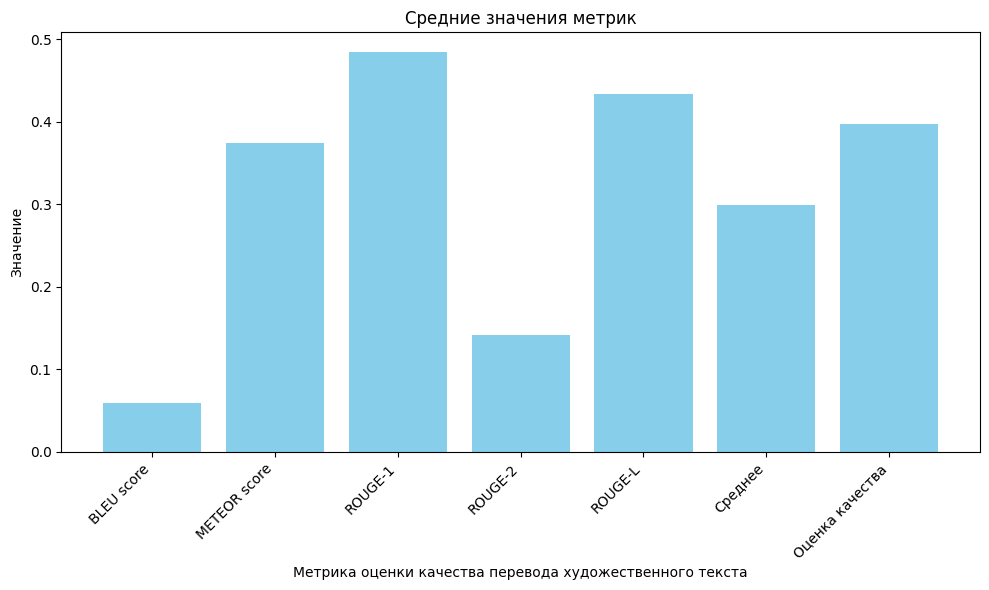

In [14]:
# Средние значения метрик
metrics_names = ['BLEU score', 'METEOR score', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Среднее', 'Оценка качества']
metrics_values = [average_bleu, average_meteor, average_rouge_1, average_rouge_2, average_rouge_l, average, art_met]

# Создание диаграммы
plt.figure(figsize=(10, 6))
plt.bar(metrics_names, metrics_values, color='skyblue')
plt.title('Средние значения метрик')
plt.xlabel('Метрика оценки качества перевода художественного текста')
plt.ylabel('Значение')
plt.xticks(rotation=45, ha='right')  # Поворот подписей по оси X для лучшей читаемости
plt.tight_layout()

# Отображение диаграммы
plt.show()


Этот фрагмент кода определяет функцию `load_text`, которая загружает текст из файла и возвращает его содержимое. Затем он загружает эталонный текст из файла с помощью этой функции и выводит результат его предобработки:

In [15]:
# Функция для загрузки текста из файла
def load_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:  # Открытие файла для чтения с указанием кодировки UTF-8
        text = file.read()  # Чтение содержимого файла и сохранение в переменную text
    return text  # Возвращение загруженного текста

# Загрузка эталонного текста
reference_text = load_text('reference.txt')

# Проверка содержимого файла после предобработки
print("Текст после предобработки:\n", preprocess_text(reference_text))

Текст после предобработки:
 one consid mr. sherlock holm activ practic twenty-thre year , seventeen allow cooper keep note do , clear mass materi command . problem alway find choos . long row year-book fill shelf , dispatch-cas fill document , perfect quarri student crime social offici scandal late victorian era . concern latter , may say writer agon letter , beg honour famili reput famous forebear may touch , noth fear . discret high sens profession honour alway distinguish friend still work choic memoir , confid abus . deprec , howev , strongest way attempt mode late get destroy paper . sourc outrag known , repeat mr. holm 's author say whole stori concern politician , lighthous , train cormor given public . least one reader understand . reason suppos everi one case gave holm opportun show curious gift instinct observ endeavour set fourth memoir . sometim much effort pick fruit , sometim fell easili lap . terribl human tragedi often involv case brought fewest person opportun , one de

Этот фрагмент кода `загружает и выводит эталонный текст до и после его предобработки`. Затем он загружает и выводит переведенный текст до и после его предобработки:

In [16]:
# Загрузка эталонного текста до и после предобработки
print("Original reference text:")
print(reference_text)
reference_text_preprocessed = preprocess_text(reference_text)
print("Preprocessed reference text:")
print(reference_text_preprocessed)

# Загрузка переведенного текста до и после предобработки
print("Original translated text:")
print(translated_text)
translated_text_preprocessed = preprocess_text(translated_text)
print("Preprocessed translated text:")
print(translated_text_preprocessed)

Original reference text:
When one considers that Mr. Sherlock Holmes was in active practice for twenty-three years, and that during seventeen of these I was allowed to cooperate with him and to keep notes of his doings, it will be clear that I have a mass of material at my command. The problem has always been not to find but to choose. There is the long row of year-books which fill a shelf, and there are the dispatch-cases filled with documents, a perfect quarry for the student not only of crime but of the social and official scandals of the late Victorian era. Concerning these latter, I may say that the writers of agonized letters, who beg that the honour of their families or the reputation of famous forebears may not be touched, have nothing to fear. The discretion and high sense of professional honour which have always distinguished my friend are still at work in the choice of these memoirs, and no confidence will be abused. I deprecate, however, in the strongest way the attempts wh